In [1]:
from fastbook import *
from ddgs import DDGS

In [2]:
with DDGS() as ddgs:
    results = ddgs.images("bird photos", max_results=1, safesearch="off", region="us-en")
    urls = [r["image"] for r in results]
    print(len(urls), urls[0])

1 https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg


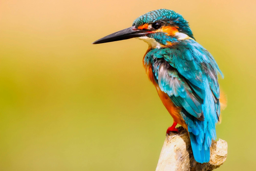

In [3]:
# Download an image of a bird
dest = Path('bird.jpg')
if not dest.exists():
    download_url(urls[0], dest, show_progress=False)

# Open and display the image as a thumbnail
im = Image.open(dest)
im.to_thumb(256, 256)

In [4]:
# ==========================================
#  BIRD vs FOREST DATASET CREATOR (FASTAI)
# ==========================================

from fastai.vision.all import *
from ddgs import DDGS
from itertools import chain
from pathlib import Path
import time

 Searching: bird
 Searching: wild bird
 Searching: bird flying
 Searching: colorful bird
 Searching: small bird
 Searching: songbird
 Searching: eagle bird
 Searching: blue jay
 Searching: sparrow
 Searching: kingfisher
✅ BIRD: 91 clean URLs found
📸 bird: 461 valid images remaining after cleanup

 Searching: forest
 Searching: rainforest
 Searching: pine forest
 Searching: autumn forest
 Searching: jungle
 Searching: woods
 Searching: green forest
 Searching: dense forest
 Searching: forest landscape
 Searching: forest trail
 Searching: fire forest
 Searching: love forest
 Searching: Big forest
 Searching: sea forest
 Searching: Amazon forest
 Searching: lake forest
 Searching: summer forest
 Searching: winter forest
 Searching: spring forest
 Searching: midwest forest
 Searching: snow forest
✅ FOREST: 57 clean URLs found
📸 forest: 167 valid images remaining after cleanup

⚠️ Warning: only 167 forest images — try rerunning or relaxing filters.

forest: 167 images total
.DS_Store: 0 ima

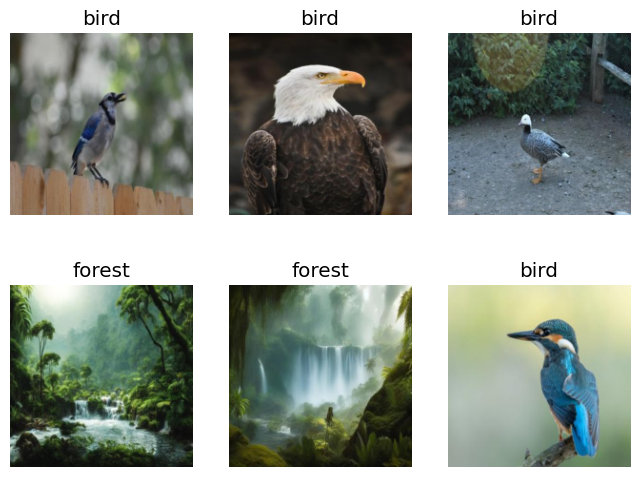

In [8]:
# ------------------------------------------
# Helper: search DuckDuckGo for clean images
# ------------------------------------------
def ddg_urls(query, max_results=300, region="us-en", safesearch="moderate"):
    q = f'{query} photo -logo -watermark -vector -icon -clipart -illustration -drawing'
    with DDGS() as ddgs:
        return [r["image"] for r in ddgs.images(q, max_results=max_results,
                                                region=region, safesearch=safesearch)]

# ------------------------------------------
# Helper: whitelist / blacklist domains
# ------------------------------------------
GOOD_DOMAINS = (
    "pexels.com", "unsplash.com", "wikimedia.org",
    "pixabay.com", "staticflickr.com", "freeimages.com"
)
BAD_TOKENS = ("alamy", "gettyimages", "shutterstock", "123rf",
              "dreamstime", "depositphotos", "istockphoto")

def keep_clean(url):
    u = url.lower()
    return any(d in u for d in GOOD_DOMAINS) and not any(b in u for b in BAD_TOKENS)

# ------------------------------------------
# Search keywords for each category
# ------------------------------------------
searches = {
    "bird": [
        "bird", "wild bird", "bird flying", "colorful bird", "small bird",
        "songbird", "eagle bird", "blue jay", "sparrow", "kingfisher"
    ],
    "forest": [
        "forest", "rainforest", "pine forest", "autumn forest", "jungle",
        "woods", "green forest", "dense forest", "forest landscape", "forest trail","fire forest",
        "love forest","Big forest","sea forest","Amazon forest","lake forest","summer forest","winter forest",
        "spring forest","midwest forest","snow forest"
    ]
}

# ------------------------------------------
# Download and prepare dataset
# ------------------------------------------
path = Path("bird_or_not")
path.mkdir(exist_ok=True)

TARGET_COUNT = 200  # number of images you want per class

for label, queries in searches.items():
    dest = path / label
    dest.mkdir(exist_ok=True)
    url_lists = []
    for q in queries:
        print(f" Searching: {q}")
        urls = ddg_urls(q, max_results=400)
        url_lists.append(urls)
        time.sleep(2)  # small delay to avoid rate-limits

    # Flatten & filter
    urls = list({u for u in chain.from_iterable(url_lists) if keep_clean(u)})
    print(f"✅ {label.upper()}: {len(urls)} clean URLs found")

    # Limit to target number
    urls = urls[:TARGET_COUNT * 2]  # over-fetch a bit in case some fail

    # Download & resize
    download_images(dest, urls=urls, timeout=15)
    resize_images(dest, max_size=400, dest=dest)

    # Remove bad files
    failed = verify_images(get_image_files(dest))
    failed.map(Path.unlink)

    # If fewer than target, print a warning
    remaining = len(get_image_files(dest))
    print(f"📸 {label}: {remaining} valid images remaining after cleanup\n")
    if remaining < TARGET_COUNT:
        print(f"⚠️ Warning: only {remaining} {label} images — try rerunning or relaxing filters.\n")

# ------------------------------------------
# Show summary
# ------------------------------------------
for folder in path.ls():
    count = len(get_image_files(folder))
    print(f"{folder.name}: {count} images total")

# ------------------------------------------
# Preview sample images
# ------------------------------------------
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6, figsize=(8,6))

In [9]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/muhammadimran/miniforge3/lib/python3.12/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,0.845456,0.028411,0.008000,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.100525,0.016035,0.000000,00:10
1,0.070941,0.009776,0.000000,00:09
2,0.048235,0.002608,0.000000,00:09


In [10]:
is_bird, _, probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9971


In [11]:
import matplotlib.pyplot as plt

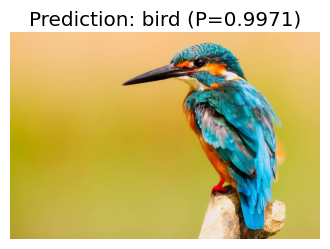

In [14]:
img = PILImage.create('bird.jpg')
is_bird, _, probs = learn.predict(img)

img.show(figsize=(4,4))
plt.title(f"Prediction: {is_bird} (P={probs[0]:.4f})")
plt.show()

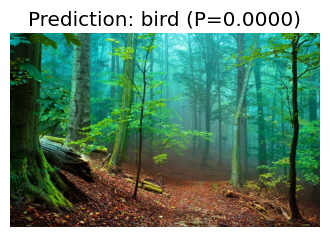

In [13]:
img = PILImage.create('bird1.jpg')
is_bird1, _, probs = learn.predict(img)

img.show(figsize=(4,4))
plt.title(f"Prediction: {is_bird} (P={probs[0]:.4f})")
plt.show()

In [1]:
#Three Layers Convolution Neural Network on MNIST Data 

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [39]:
#True means its a package and module, but False means its only module
print(hasattr(torch.nn.functional,'__path__'))

False


In [70]:
print(hasattr(datasets,'__path__'))
print(hasattr(datasets.MNIST,'__path__'))
print(hasattr(DataLoader,'__path__'))

True
False
False


In [3]:
#load MNIST (handwritten digits)

In [4]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 14546218.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 1358023.47it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 8204186.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 4023342.93it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [72]:
#help(datasets.MNIST)

In [73]:
import inspect

In [77]:
print(inspect.signature(DataLoader))

(dataset: torch.utils.data.dataset.Dataset[+T_co], batch_size: Optional[int] = 1, shuffle: Optional[bool] = None, sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None, batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None, num_workers: int = 0, collate_fn: Optional[Callable[[List[~T]], Any]] = None, pin_memory: bool = False, drop_last: bool = False, timeout: float = 0, worker_init_fn: Optional[Callable[[int], NoneType]] = None, multiprocessing_context=None, generator=None, *, prefetch_factor: Optional[int] = None, persistent_workers: bool = False, pin_memory_device: str = '')


In [79]:
sig = inspect.signature(DataLoader)
len(sig.parameters)

16

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader

In [ ]:
# Define a transform to convert each MNIST image to a PyTorch tensor (scales pixel values 0–255 → 0–1)
transform = transforms.ToTensor()

# Load the MNIST training dataset (60,000 images)
# - root="./data" : directory where the dataset will be stored or loaded from
# - train=True    : use the training split of MNIST
# - download=True : download automatically if not already present
# - transform     : apply the ToTensor() conversion to each image
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

# Load the MNIST testing dataset (10,000 images)
# - train=False   : use the test split
# - transform     : apply the same tensor conversion for consistency
test_data = datasets.MNIST(root="./data", train=False, transform=transform)

# Create the DataLoader for training
# - batch_size=64 : each batch will contain 64 images and labels
# - shuffle=True  : randomize order each epoch to improve learning
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Create the DataLoader for testing
# - batch_size=64 : same batch size for evaluation
# - shuffle=False : keep test order fixed for consistent results
test_loader = DataLoader(test_data, batch_size=64)

In [7]:
# Define a tiny 3-layer CNN

In [8]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)   # 1→8 channels
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)  # 8→16
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1) # 16→32
        self.fc = nn.Linear(32*3*3, 10)              # final classifier (10 digits)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # 28→14
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 14→7
        x = F.relu(F.max_pool2d(self.conv3(x), 2))  # 7→3
        x = x.view(-1, 32*3*3)                      # flatten
        x = self.fc(x)
        return x

In [9]:
# Training setup

In [10]:
model = TinyCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [80]:
print(inspect.signature(torch.optim.Adam))

(params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]], lr: Union[float, torch.Tensor] = 0.001, betas: Tuple[float, float] = (0.9, 0.999), eps: float = 1e-08, weight_decay: float = 0, amsgrad: bool = False, *, foreach: Optional[bool] = None, maximize: bool = False, capturable: bool = False, differentiable: bool = False, fused: Optional[bool] = None)


In [81]:
sig1 = inspect.signature(torch.optim.Adam)
len(sig1.parameters)

11

In [82]:
for param in model.parameters():
    print(param.shape)

torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([10, 288])
torch.Size([10])


In [109]:
T = torch.tensor([[1, 1, 1],[0,1,1]]) 
print(T)
print(T.size())
T1 = torch.tensor([10]) 

tensor([[1, 1, 1],
        [0, 1, 1]])
torch.Size([2, 3])


In [110]:
T1.item()

10

In [103]:
print(inspect.signature(nn.CrossEntropyLoss()))

(*args, **kwargs)


In [104]:
hasattr(nn.CrossEntropyLoss(),'__path__')

False

In [11]:
# Train for a few epochs

In [12]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"epoch {epoch+1}, loss {total_loss/len(train_loader):.4f}")

epoch 1, loss 0.3696
epoch 2, loss 0.0941
epoch 3, loss 0.0695


In [107]:
hasattr(optimizer.zero_grad(),'__path__')
hasattr(optimizer.step(),'__path__')


False

In [13]:
# Quick test accuracy

In [14]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        preds = model(x)
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)
print(f"accuracy: {correct/total:.3f}")

accuracy: 0.986


In [111]:
preds = torch.tensor([[2.5, 0.3, 0.1],
                      [0.2, 3.1, 0.5],
                      [0.1, 0.4, 0.9]])
y = torch.tensor([0, 1, 0])

print(preds.argmax(1))          # tensor([0, 1, 2])
print((preds.argmax(1) == y))   # tensor([True, True, False])
print((preds.argmax(1) == y).sum().item())  # 2

tensor([0, 1, 2])
tensor([ True,  True, False])
2


In [18]:
import matplotlib.pyplot as plt

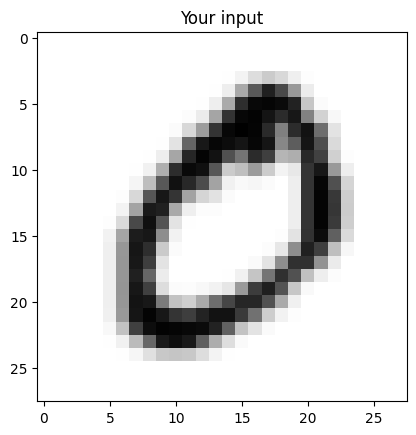

Predicted digit: 6


In [20]:
from PIL import Image
from torchvision import transforms

# load and preprocess
img = Image.open("Zero.png").convert("L")   # convert to grayscale
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])
x = transform(img).unsqueeze(0)  # [1, 1, 28, 28]

plt.imshow(x.squeeze(), cmap='gray')
plt.title("Your input")
plt.show()

# predict
model.eval()
with torch.no_grad():
    preds = model(x)
    predicted_label = preds.argmax(1).item()

print(f"Predicted digit: {predicted_label}")



In [27]:
# 1️⃣ Load and transform image
img = Image.open("zero.png").convert("L")     # grayscale
img_inverted = ImageOps.invert(img)                # invert to white-on-black
transform = transforms.Compose([
    transforms.Resize((28, 28)),                   # match MNIST size
    transforms.ToTensor(),
])
x = transform(img_inverted).unsqueeze(0) 

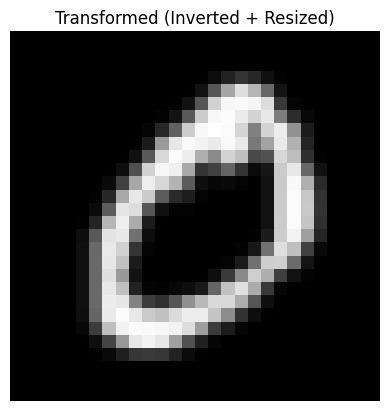

In [28]:
# 2️⃣ Display the transformed image
plt.imshow(x.squeeze(), cmap='gray')
plt.title("Transformed (Inverted + Resized)")
plt.axis("off")
plt.show()

In [29]:
# 3️⃣ Predict the digit
model.eval()
with torch.no_grad():
    preds = model(x)
    predicted = preds.argmax(1).item()

print(f"Predicted digit: {predicted}")

Predicted digit: 0


In [30]:
import torch
print(torch.__file__)

/Users/muhammadimran/miniforge3/lib/python3.12/site-packages/torch/__init__.py


In [40]:
from torchvision import transforms
from PIL import Image
import torch

transform = transforms.ToTensor()
img = Image.open("zero.png")    # PIL Image

tensor_img = transform(img)    # Apply transformation

In [46]:
tensor_img.size()

torch.Size([4, 776, 776])

In [49]:
print(img.size)

(776, 776)


In [51]:
img[0,0]

TypeError: 'PngImageFile' object is not subscriptable

In [52]:
img.getpixel((0,0))

(255, 255, 255, 255)

In [55]:
print(hasattr(img.getpixel,'__path__'))

False


In [59]:
import numpy as np
imgarr = np.array(img)
imgarr.shape

(776, 776, 4)

In [61]:
import PIL

In [62]:
print(hasattr(PIL,'__path__'))

True


In [65]:
print(PIL.__path__)

['/Users/muhammadimran/miniforge3/lib/python3.12/site-packages/PIL']


In [112]:
import os

In [113]:
os.getcwd()

'/Users/muhammadimran/Desktop/Residency_1Year/My_Work/Research_Data/Coding_Work'